### Import Libraries

Import all necessary libraries for data manipulation, machine learning, and model interpretation.

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, roc_auc_score
from sklearn.ensemble import HistGradientBoostingClassifier

import matplotlib.pyplot as plt
import shap

/home/est-lul/Documents/Projects/insurance_risk_analytics/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and Prepare Data

Load the cleaned insurance dataset and create a binary target column (`HasClaim`) indicating whether a claim was made.

In [2]:
df = pd.read_parquet('../../data/clean_data.parquet')
df['HasClaim'] = df['TotalClaims'].apply(lambda x: 1 if x > 0 else 0)

### Handle Missing Values

Check for missing values, fill missing numerical values with the median, and drop rows with excessive missing data.

In [3]:
# Check for missing values
print(df.isnull().sum())

# Fill missing values with median (for numerical features)
df.fillna(df.median(numeric_only=True), inplace=True)

# Drop rows with excessive missing values
df.dropna(thresh=df.shape[1]*0.8, inplace=True)

Unnamed: 0                       0
UnderwrittenCoverID              0
PolicyID                         0
TransactionMonth                 0
IsVATRegistered                  0
Citizenship                      0
LegalType                        0
Title                            0
Language                         0
Bank                        143521
AccountType                  38476
MaritalStatus                 8195
Gender                        9472
Country                          0
Province                         0
PostalCode                       0
MainCrestaZone                   0
SubCrestaZone                    0
ItemType                         0
mmcode                         525
VehicleType                    525
RegistrationYear                 0
make                           525
Model                          525
Cylinders                      525
cubiccapacity                  525
kilowatts                      525
bodytype                       525
NumberOfDoors       

### Feature Engineering

Create new features: `VehicleAge` (based on registration year) and `PremiumPerClaimRatio` (premium per claim, avoiding division by zero).

In [4]:
df['VehicleAge'] = 2025 - df['RegistrationYear']
df['PremiumPerClaimRatio'] = df['TotalPremium'] / (df['TotalClaims'] + 1) # Avoid division by zero

### Encode Categorical Features

Apply label encoding to categorical columns so they can be used in machine learning models.

In [5]:
# Apply label encoding to categorical features
important_cols = ['TransactionMonth', 'LegalType', 'Title', 'Gender', 
                    'Province', 'ItemType','VehicleType', 'RegistrationYear', 
                    'make', 'Model', 'CustomValueEstimate', 'TrackingDevice', 
                    'CapitalOutstanding', 'SumInsured', 'TermFrequency', 
                    'CalculatedPremiumPerTerm','CoverType', 'TotalPremium',
                    'VehicleAge', 'PremiumPerClaimRatio']
categorical_cols = ['TransactionMonth', 'LegalType', 'Title', 'Gender', 
                    'Province', 'ItemType', 'VehicleType', 'make', 'Model', 
                    'TermFrequency' , 'CoverType', 'TrackingDevice']
# categorical_cols = ['VechileType', 'Province', 'CoverType', ]
encoder = LabelEncoder()
df[categorical_cols] = df[categorical_cols].apply(encoder.fit_transform)

### Prepare Features and Target

Select important columns for modeling and split the data into features (`X`) and target (`y`), then create train/test splits.

In [6]:
# X = df[df['HasClaim'] == 1][important_cols]
# y = df[df['HasClaim'] == 1]['TotalClaims']

X = df[important_cols]
y = df['TotalClaims']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Check Feature Matrix Shape

Display the shape of the feature matrix to confirm the number of samples and features.

In [7]:
X.shape

(987346, 20)

### Train Claim Severity Prediction Model

Train an XGBoost regressor to predict claim severity using the training data.

In [8]:
# Train claim prediction model
reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05)
reg.fit(X_train, y_train,
                   eval_set=[(X_train, y_train),(X_test, y_test)],
                   verbose=1000)

[0]	validation_0-rmse:1780.91023	validation_1-rmse:1762.17055
[99]	validation_0-rmse:691.64007	validation_1-rmse:1064.68925


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Evaluate Regression Model

Predict on the test set and evaluate the regression model using RMSE and R² metrics.

In [9]:
# Predict & evaluate
y_pred = reg.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, R²: {r2:.2f}")

RMSE: 1064.69, R²: 0.66


### Feature Importance

Plot the feature importances from the trained XGBoost regressor to understand which features influence predictions most.

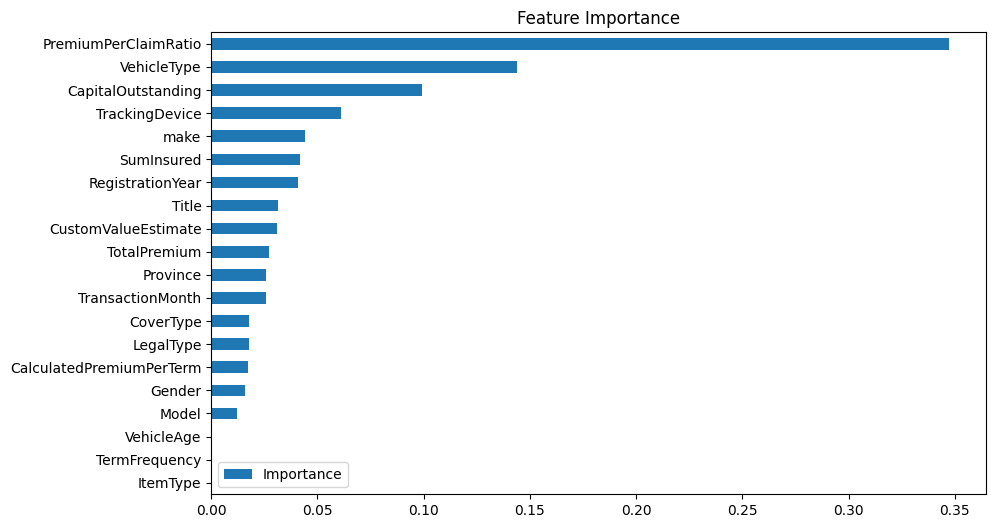

In [10]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['Importance']).sort_values(by='Importance',
                                                  ascending=True)

fi.plot(kind='barh', figsize=(10, 6), title='Feature Importance')
plt.show()

### Train Claim Frequency Model

Train a `HistGradientBoostingClassifier` to predict the probability of a claim (`HasClaim`).

In [11]:
# Define binary target
X_claim = df[important_cols]
y_claim = df['HasClaim']

# Split data
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_claim, y_claim, test_size=0.2, random_state=42)

# Train model for claim occurrence
model_freq = HistGradientBoostingClassifier(max_iter=200, learning_rate=0.1)
model_freq.fit(Xc_train, yc_train)

,loss,'log_loss'
,learning_rate,0.1
,max_iter,200
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'
,monotonic_cst,None


### Evaluate Claim Frequency Model

Predict and evaluate the classifier using accuracy and ROC AUC metrics.

In [12]:
# Predict and evaluate
y_pred = model_freq.predict(Xc_test)
y_proba = model_freq.predict_proba(Xc_test)[:, 1]

print("Accuracy:", accuracy_score(yc_test, y_pred))
print("ROC AUC:", roc_auc_score(yc_test, y_proba))

Accuracy: 0.9997822454043652
ROC AUC: 0.995890039264942


### Premium Calculation Function

Define a function to calculate risk-based premiums using predicted claim probability and severity.

In [13]:
def calc_premium(p_claim, e_claim, expense=0.15, margin=0.10):
    """Return risk-based premium in ZAR."""
    return (p_claim * e_claim) / (1 - expense - margin)

### Predict and Calculate Optimized Premiums

Predict claim probability and severity for all records, then calculate optimized premiums using the custom function.

In [14]:
df["PredictedClaimProb"] = model_freq.predict_proba(df[important_cols])[:, 1]
df["PredictedClaimSeverity"] = reg.predict(df[important_cols])

# Calculate optimized premiums
df["OptimizedPremium"] = df.apply(lambda row: calc_premium(row["PredictedClaimProb"], row["PredictedClaimSeverity"]), axis=1)


### Show Predictions and Optimized Premiums

Display the predicted claim probability, severity, and optimized premium for each record.

In [15]:
df[['PredictedClaimProb', 'PredictedClaimSeverity', 'OptimizedPremium']]

,PredictedClaimProb,PredictedClaimSeverity,OptimizedPremium
0,0.000003,2.755011,0.000013
1,0.000003,1.687364,0.000008
2,0.000054,3.295607,0.000238
3,0.000003,-1.073638,-0.000005
4,0.000011,18.470322,0.000264
...,...,...,...
987341,0.000003,10.855283,0.000050
987342,0.000003,10.855283,0.000051
987343,0.000004,10.855283,0.000051
987344,0.000004,-0.937579,-0.000004


### SHAP Feature Importance Visualization

Use SHAP to explain the XGBoost model's predictions and visualize feature importance.

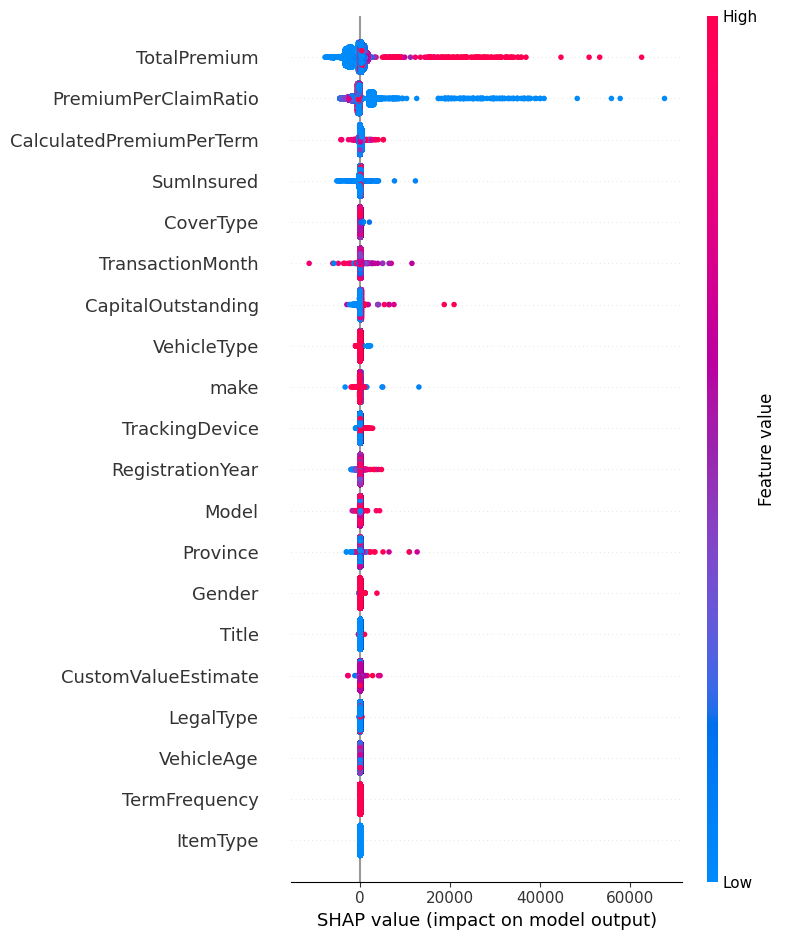

In [16]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test)